In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim

import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader, Subset, Dataset

from tqdm import tqdm
from typing import List,Tuple


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/bradley/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ts = [T.ToTensor(), T.Resize((32, 32)), T.Normalize([0.5], [0.5])]
mnist_train = datasets.MNIST(
    root='dat',
    train=True,
    download=True,
    transform=T.Compose(ts)
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(1, 128, 5, 2, 2),
            nn.LeakyReLU(.2),

            nn.Conv2d(128, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(.2),

            nn.Conv2d(256, 512, 5, 2, 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(.2),

            nn.Conv2d(512, 1024, 5, 2, 2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(.2),

            nn.Flatten(),
            nn.Linear(2*2*1024, 1),
            nn.Sigmoid()
        )

    def forward(self, X):
        out = self.dis(X)
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100, 2*2*1024),
            nn.BatchNorm1d(2*2*1024),
            nn.ReLU(),

            nn.Unflatten(1, (1024, 2, 2)),
            nn.ConvTranspose2d(1024, 512, 5, 2, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 5, 2, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 5, 2, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 1, 5, 2, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.gen(z)
        return out

In [ ]:
fixed = torch.randn([1, 100]).to(DEVICE)

In [ ]:
def train(gen, dis, opt_gen, opt_dis, dl, epochs):
    bce = nn.BCELoss()

    for i in tqdm(range(epochs)):
        gen.train()
        dis.train()
        for j, (X, _) in enumerate(dl):
            X = X.to(DEVICE)

            
            # train discriminator
            # real batch
            opt_dis.zero_grad()
            out = dis(X)
            real_label = torch.full_like(out, 1)
            loss_real = bce(out, real_label)
            loss_real.backward()
            
            l_real.append(loss_real.detach().cpu())
            
            z = torch.randn((X.shape[0], 100)).to(DEVICE)
            fake_gen = gen(z)

            # fake batch
            out = dis(fake_gen.detach())
            fake_label = torch.full_like(out, 0)
            loss_fake = bce(out, fake_label)
            loss_fake.backward()
            opt_dis.step()
            
            l_fake.append(loss_fake.detach().cpu())
            loss_dis = loss_real + loss_fake
            l_dis.append(loss_dis.detach().cpu())

            # train generator
            opt_gen.zero_grad()
            out = dis(fake_gen)
            loss_gen = bce(out, real_label)
            loss_gen.backward()
            opt_gen.step()

            l_gen.append(loss_gen.detach().cpu())
        
        # print updates
        if i % 2 == 0:
            to_img = T.ToPILImage()
            gen.eval()
            dis.eval()
            out = gen(fixed)
            print()
            print(dis(out).item())
            display(to_img(out.view(-1, 32, 32)))

In [ ]:
l_real = []
l_fake = []
l_dis = []
l_gen = []

gen = Generator().to(DEVICE)
dis = Discriminator().to(DEVICE)

opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5,.999))
opt_dis = optim.Adam(dis.parameters(), lr=2e-4, betas=(0.5,.999))

if False:
    dl = DataLoader(Subset(mnist_train, range(500)), batch_size=64, shuffle=True)
elif False:
    dl = DataLoader(Subset(mnist_train, range(5000)), batch_size=64, shuffle=True)
else:
    dl = DataLoader(mnist_train, batch_size=64, shuffle=True)

  0%|          | 0/10 [00:00<?, ?it/s]


0.1488572061061859


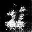

 20%|██        | 2/10 [11:02<44:07, 330.93s/it]


0.027157967910170555


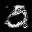

 40%|████      | 4/10 [22:00<32:57, 329.50s/it]


0.192057803273201


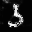

 60%|██████    | 6/10 [32:57<21:55, 328.97s/it]


0.07435236126184464


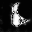

 80%|████████  | 8/10 [43:55<10:57, 328.88s/it]


0.06834069639444351


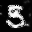

100%|██████████| 10/10 [54:55<00:00, 329.55s/it]


In [ ]:
train(
    gen,
    dis,
    opt_gen,
    opt_dis,
    dl,
    10,
)

In [ ]:
torch.save(gen.state_dict(), 'gen.pth')
torch.save(dis.state_dict(), 'dis.pth')

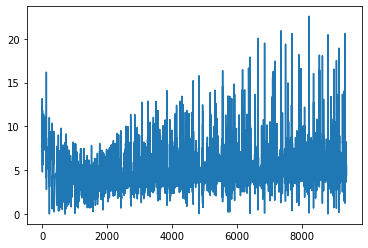

In [ ]:
plt.plot(l_gen)

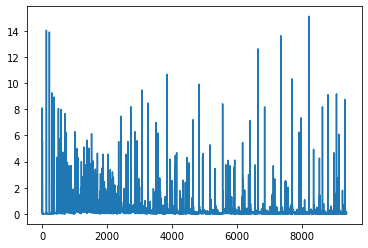

In [ ]:
plt.plot(l_dis)

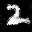

tensor([[0.1729]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
z = torch.randn((1, 100)).to(DEVICE)
gen.eval()
img = gen(z).view(-1, 32, 32)
display(T.ToPILImage()(img))

dis.eval()
print(dis(gen(z)))

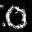

In [ ]:
display(T.ToPILImage()(gen(fixed).view(-1, 32, 32)))